In [8]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import log_softmax, pad

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import copy
import math
from tqdm import tqdm

# ATTENTION

In [2]:
def generate_data(N=10000):
    x = np.random.uniform(-1.0, 1.0, N)
    epsilon = (0.5 + 2 * np.abs(x)) * np.random.randn(N)
    y_true = 0.8 * x ** 2 - 0.5 * x + np.sin(5 * x) + 0.5 * np.log(np.abs(x))
    y_real = y_true + epsilon
    return x, y_true, y_real

def plot_figure(x, y, X, Y, label):
    fig, ax = plt.subplots()
    plt.scatter(X, Y, s=1, label='Train Data')
    plt.scatter(x, y, s=10, label=label)
    ax.legend()
    plt.show()

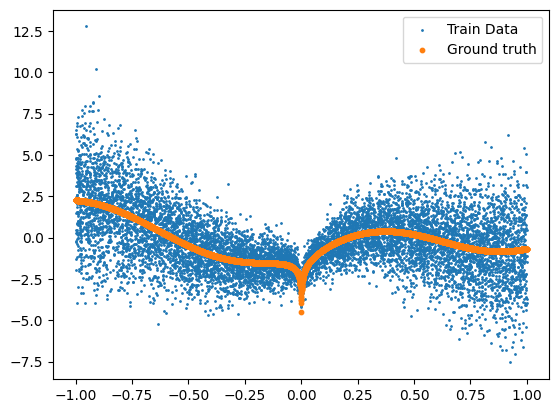

In [3]:
X, Y_gt, Y = generate_data()
plot_figure(X, Y_gt, X, Y, 'Ground truth')

In [4]:
class Attention():
    def __init__(self, key, value, scoring='dot_product', len=0.1):
        self.key = key
        self.value = value
        self.len = len
    
        if scoring == 'dot_product':
            self.scoring = self._dot_scoring_function

        elif scoring == 'laplace':
            self.scoring = self._laplace_scoring_function

        elif scoring == 'gaussian':
            self.scoring = self._gaussian_scoring_function

        elif scoring is None:
            self.scoring = self._dot_scoring

        else:
            raise NotImplementedError

    def compute_attention(self, query, keys, values, len):
        attention_weight = self.compute_attention_weights(query, keys, len) # attention weight 계산(softmax 취한 attention score)
        # 'key에 대응되는 attention weight'와 'key에 대응되는 value'를 곱하기 위해 value의 차원을 맞춰준다.
        values = np.repeat(values.reshape(1,-1,1), repeats=attention_weight.shape[0], axis=0)
        unnormalize_attention = np.multiply(attention_weight, values) # attention weight * value
        attention = np.sum(unnormalize_attention, axis=1) # 모든 attention weight * value 를 더한다.

        return attention
    
    
    def compute_attention_weights(self, query, keys, len):
        query, keys = self._reshape_query_keys(query, keys) # query와 각각의 key에 대해 attention 연산을 적용하기 위해 차원을 맞춰준다.
        attention_logits = self.scoring(query, keys, len)   # query와 각각의 key에 대해 scoring 연산 진행 >> attention score
        attention_weight = self._compute_softmax(attention_logits) # 각각의 key에 대응되는 attention socre에 대해 softmax를 취해준다.

        return attention_weight

    @staticmethod
    def _reshape_query_keys(query, keys):
        X = np.repeat(keys.reshape(1,-1,1), repeats=query.shape[0], axis=0)
        x = np.repeat(query.reshape(-1,1,1), repeats=keys.shape[0], axis=1)

        return x, X
    
    @staticmethod
    def _dot_scoring_function(query, keys, len=0.1):
        score = query*keys/len

        return score
    
    @staticmethod
    def _gaussian_scoring_function(query, keys, len=0.1):
        score = - 0.5 * (query - keys)**2 / len
        return score

    @staticmethod
    def _laplace_scoring_function(query, keys, len=0.1):
        score = - np.abs(query - keys) / len
        return score
    
    @staticmethod
    def _compute_softmax(vec):
        numerator = np.exp(vec) # 해당 key(i번째)에 대응되는 attention score 값 >> a(q,k_i)
        denominator = np.repeat(np.sum(numerator, axis=1).reshape(-1,1,1), numerator.shape[1], axis=1) # 전체 attention score의 합
        softmax = np.divide(numerator, denominator)

        return softmax
    
    def __call__(self, query):
        return self.compute_attention(query, self.key, self.value, self.len) # attentio mechanism을 이용하여 regression 실행

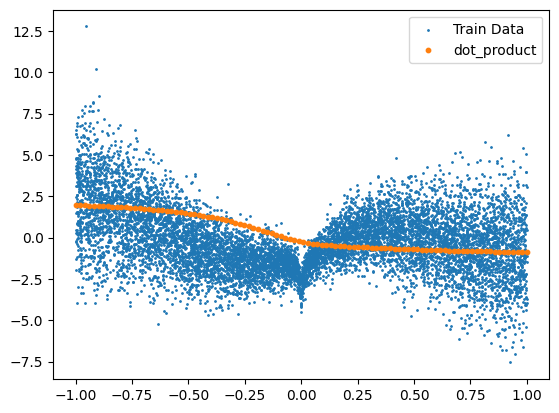

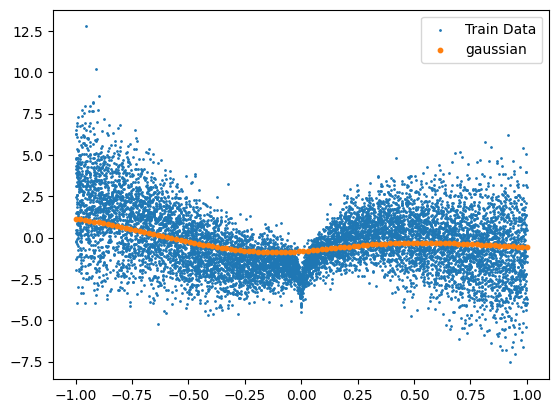

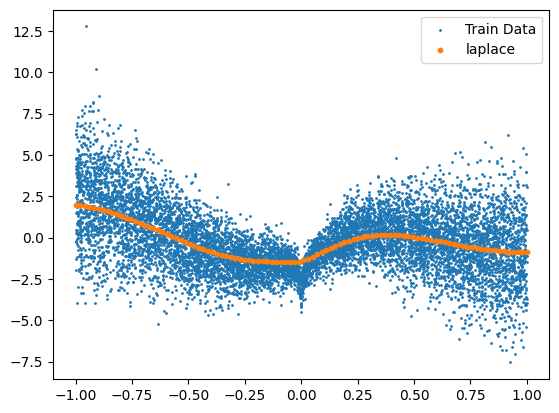

In [5]:
test_input = np.linspace(-1,1,100)

attention = Attention(X, Y, scoring='dot_product') # attention instance 생성
result = attention(test_input) # call 호출
plot_figure(test_input, result, X, Y, label='dot_product')

attention = Attention(X, Y, scoring='gaussian')
result = attention(test_input)
plot_figure(test_input, result, X, Y, label='gaussian')

attention = Attention(X, Y, scoring='laplace')
result = attention(test_input)
plot_figure(test_input, result, X, Y, label='laplace')

In [6]:
def plot_heatmap(scoring_fun, grid, label):
    xv, yv = grid
    score = scoring_fun(xv.reshape(-1, 1), yv.reshape(-1, 1))
    score = score.reshape(len(test_input), len(test_input))
    score = np.exp(score)
    numerator = np.repeat(np.sum(score, axis=1).reshape(-1, 1), score.shape[1], axis=1)
    attention_weight = score / numerator
    df = pd.DataFrame(attention_weight, columns=np.round(test_input, 2), index=np.round(test_input, 2))
    sns.heatmap(df, cmap="rocket_r", xticklabels=8, yticklabels=8).set_title(label)
    plt.show()

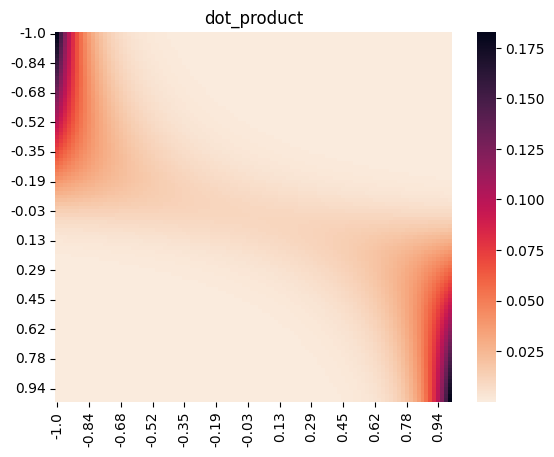

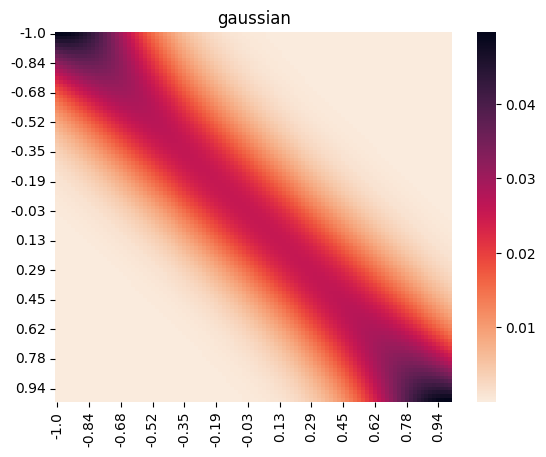

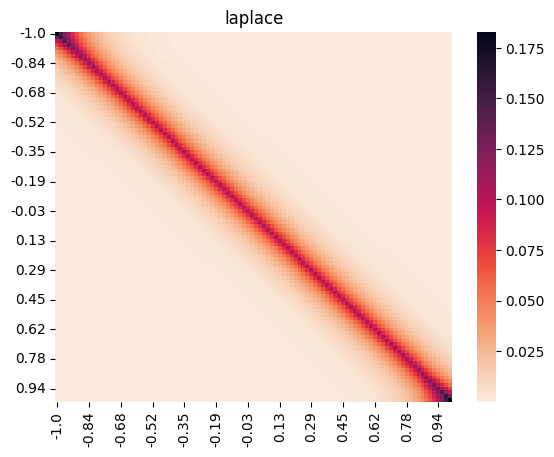

In [7]:
grid = np.meshgrid(test_input, test_input)

plot_heatmap(scoring_fun=Attention._dot_scoring_function, grid=grid, label="dot_product")
plot_heatmap(scoring_fun=Attention._gaussian_scoring_function, grid=grid, label="gaussian")
plot_heatmap(scoring_fun=Attention._laplace_scoring_function, grid=grid, label="laplace")

# TRANSFORMER

In [3]:
d_attn = 512 # self-attention output의 dimension
d_ffn = 2046
num_layer = 6 # 연속해서 쌓은 block 개수
num_mha = 8   # multi-head 개수

In [10]:
def clone_modules(module, N): # block을 연속해서 쌓는 테크닉 , N=6 -> 6번 반복해서 module을 쌓는다.
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)]) # deepcopy로 메모리가 분리된 모듈들을 쌓는다. 간섭 방지

# batch norm : batch에 있는 "모든 sample에 대해서" "각 feuture의 평균과 분산을 구해서 정규화"한다.
# layer norm : "각 sample에 대해서" sample안에 있는 "모든 feature에 대해서 평균과 분산을 구해서 정규화"한다.

class LayerNorm(nn.Module): # 한 input의 dimension에 대해서 normalization , nn.Module 상속받으면 하나의 모듈을 만들 것이라는 의미.
    def __init__(self, features, eps=1e-6):
        super().__init__()
        # nn.Parameter : 학습과정에서 learning되게끔 parameter intialized
        self.alpha = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps # 작은 값으로 initialized

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim = True) + self.eps # std값이 너무 작아지면 normalization 값 폭발 >> overflow 방지
        normalized = (x - mean) / std
        out = self.alpha * normalized + self.beta
        return out
    
class SublayerConnection(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.norm = LayerNorm(size) # LN
    
    def forward(self, x, sublayer):
        out = x + sublayer(self.norm(x)) # sublayer(임의의 함수 하나)를 받아온 후, residual connection 해준다.
        return out
    
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d, d_ff):
        super().__init__()
        # nn.LazyLinear([output dimension size]) : input size 몰라도 되지만, 자동으로 차원 맞춰줘서 디버깅이 어렵다는 단점을 지닌다.
        self.W1 = nn.LazyLinear(d_ff)
        self.W2 = nn.LazyLinear(d)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        z = self.W1(x)
        z = self.relu(z)
        out = self.W2(z)
        return out

class PositionalEncoding(nn.Module): # text 길이가 엄청 긴 경우에는 overflow 되기에 log와 exp 트릭을 써준다.g
    def __init__(self, d, max_len=1000):
        super().__init__()

        pe = torch.zeros(max_len, d)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d, 2) *
                             -(math.log(10000.0) / d))
        pe[:, 0::2] = torch.sin(position * div_term) # 짝수
        pe[:, 1::2] = torch.cos(position * div_term) # 홀수
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        out = x + torch.Tensor(self.pe[:, :x.size(1)], requires_grad=False)
        return out

In [5]:
tensor = torch.Tensor([[1, 2, 3], [1, 2, 3]]) # (2 , 3)
Position_FFN = nn.Linear(3, 5)
out = Position_FFN(tensor)
print(out)
print(out.shape) # 2x3 3x5 => 2x5

tensor([[-0.2121, -0.6508,  0.4877,  1.1373, -2.7083],
        [-0.2121, -0.6508,  0.4877,  1.1373, -2.7083]],
       grad_fn=<AddmmBackward0>)
torch.Size([2, 5])


In [6]:
Position_FFN_lazy = nn.LazyLinear(10)
out_l = Position_FFN_lazy(tensor)
print(out_l)
print(tensor.shape) # 2x3
print(out_l.shape) # 2x(10)

tensor([[ 0.1855, -0.1239, -1.5906,  1.4619, -0.7175, -1.1373, -0.4041,  0.3560,
          0.3687,  0.2476],
        [ 0.1855, -0.1239, -1.5906,  1.4619, -0.7175, -1.1373, -0.4041,  0.3560,
          0.3687,  0.2476]], grad_fn=<AddmmBackward0>)
torch.Size([2, 3])
torch.Size([2, 10])


/opt/conda/envs/llmenv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, num_head, dimension):
        super().__init__()

        self.h = num_head # num_mha = 8
        self.d = dimension # d_atten(self-attention output의 dimension)이 512 차원

        assert self.d % self.h == 0 # 512/8=64 이렇게 나누어 떨어지게끔 정의

        self.d_v = self.d // self.h # 각 head의 output dimension은 512/8=64가 되어야 함.

        # learnable parameter를 다른 head 들끼리 share하기 위해 정의
        self.W_q = nn.LazyLinear(self.d) # self.W_q(query)의 (1) 나머지 차원의 개수는 유지하고, (2) 마지막 차원을 512(dimension) 가 되도록 한다.
        self.W_k = nn.LazyLinear(self.d)
        self.W_v = nn.LazyLinear(self.d)
        self.W_o = nn.LazyLinear(self.d)
        self.attn = None
    
    def attention(self, query, key, value, mask=None):
        d_k = query.size(-1)

        scores = torch.einsum('bij,bkj->bik', query, key) / math.sqrt(d_k)

        if mask is not None: # when masked attention
            scores = scores.masked_fill(mask==0, -1e9) # softmax 취해줬을 때 0안나오게 하기 위해
        
        p_attn = scores.softmax(dim=-1)

        return torch.matmul(p_attn, value), p_attn
    
    def forward(self, query, key, value, mask=None):

        num_batches = query.size(0)

        if mask is not None:
            mask = mask.unsqueeze(1)

        # [num_batches, seq_len, num_head, depth]
        # multiply W_query, W_key, W_value and , shared weight이므로 같은걸 곱해준다.
        # batch의 수(num_batches), attention head의 수(self.h), head당 차원수(self.d_v)는 고정적이고, sequence length는 가변적이기에 -1로 reshape
        # transpose(1,2) >> [num_batches, num_heads, seq_len, depth]로 순서를 변경하여, head가 seuqence 내에서 각 위치에 대해 독립적으로 작업할 수 있도록 해준다.
        query = self.W_q(query).reshape(num_batches, -1, self.h, self.d_v).transpose(1, 2)
        key = self.W_k(key).reshape(num_batches, -1, self.h, self.d_v).transpose(1, 2)
        value = self.W_v(value).reshape(num_batches, -1, self.h, self.d_v).transpose(1, 2)

        x, self.attn = self.attention(query, key, value, mask)
        x = x.transpose(1,2).reshape(num_batches, -1, self.d)
        out = self.W_o(x)

        return out

In [9]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, source_embed, target_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = source_embed
        self.tgt_embed = target_embed
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        context = self.encoder(self.src_embed(src), src_mask)
        out = self.decoder(self.tgt_embed(tgt), context, src_mask, tgt_mask)

        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self, N):
        super().__init__()
        self.layers = clone_modules(self.EncoderLayer, N)
        self.norm = LayerNorm(self.EncoderLayer.size)
    
    def EncoderLayer(self, x, mask, size, self_attn, feed_forward):
        sublayer = clone_modules(SublayerConnection(size), 2)
        h = self_attn(x, x, x, mask) # self attention >> query, key, value 값 동일
        z = sublayer[0](x, h) # residaul connection + LayerNorm
        out = sublayer[1](z, feed_forward) # position-wise FFN
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        out = self.norm(x)
        return out

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super.__init__()
        self.layers = clone_modules(self.DecoderLayer, N)
        self.norm = LayerNorm(self.DecoderLayer.size)
    
    def DecoderLayer(self, x, context, src_mask, tgt_mask):        
        return
    
    def forward(self, x, context, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, context, src_mask, tgt_mask)
        return self.norm(x)